In [1]:
import sys
!{sys.executable} -m pip install --upgrade google-cloud-bigquery matplotlib numpy scipy

Requirement already up-to-date: google-cloud-bigquery in /home/jupyter-user/.local/lib/python3.7/site-packages (1.24.0)
Requirement already up-to-date: matplotlib in /home/jupyter-user/.local/lib/python3.7/site-packages (3.2.1)
Requirement already up-to-date: numpy in /home/jupyter-user/.local/lib/python3.7/site-packages (1.18.3)
Requirement already up-to-date: scipy in /home/jupyter-user/.local/lib/python3.7/site-packages (1.4.1)


The BigQuery Python client library provides a magic command that allows you to run queries with minimal code. To load the magic commands from the client library, paste the following code into the first cell of the notebook.

Type the following Python code into the next cell to import the BigQuery Python client library and initialize a client. The BigQuery client is used to send and receive messages from the BigQuery API.

In [2]:
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import json
import re

Use the Client.query() method to run a query. In the next cell, enter the following code to run a query to retrieve the annual count of plural births by plurality (2 for twins, 3 for triplets, and so on).

In [3]:
WORKFLOWID="8bcb5d62-434b-4982-9969-8d50d99a4a98"
sql = f"""
    
SELECT
    r.workflow_id, 
    r.task_call_name, 
    r.shard,
    r.instance_id,
    r.attempt,
    r.cpu_count AS cpu_obtained,
    r.cpu_platform,
    r.mem_total_gb AS mem_gb_obtained,
    r.disk_total_gb AS disk_gb_obtained,
    m.execution_status,
    m.inputs AS runtime_inputs
FROM `broad-dsde-methods.cromwell_monitoring.runtime` r, `broad-dsde-methods.cromwell_monitoring.metadata` m
WHERE 
    m.task_call_name = r.task_call_name 
    AND r.workflow_id = "8bcb5d62-434b-4982-9969-8d50d99a4a98"
    AND m.execution_status = "Done" #removes failed preembted run from table but also failed jobs
    AND DATE(m.start_time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    AND DATE(r.start_time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    
ORDER BY
    m.start_time
    
Limit 1000 
    
"""
df_meta = client.query(sql).to_dataframe()
## Show head of table 
df_meta.head()

,workflow_id,task_call_name,shard,instance_id,attempt,cpu_obtained,cpu_platform,mem_gb_obtained,disk_gb_obtained,execution_status,runtime_inputs
0,8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1,3137894415605521767,1,1,Intel Haswell,1.036321,[1.0233036800000002],Done,"[{'key': 'default_attr[""boot_disk_gb""]', 'type..."
1,8bcb5d62-434b-4982-9969-8d50d99a4a98,GetRunInfo,0,3375263385311074899,1,1,Intel Haswell,1.036325,[52.57609216],Done,"[{'key': 'default_attr[""boot_disk_gb""]', 'type..."
2,8bcb5d62-434b-4982-9969-8d50d99a4a98,ShardLongReads,0,6452021503391783505,1,2,Intel Haswell,4.140876,[4.160421888],Done,"[{'key': 'default_attr[""boot_disk_gb""]', 'type..."
3,8bcb5d62-434b-4982-9969-8d50d99a4a98,MergeCCSReports,0,2393166886278354954,1,1,Intel Haswell,1.036325,[3.1035392],Done,"[{'key': 'default_attr[""boot_disk_gb""]', 'type..."
4,8bcb5d62-434b-4982-9969-8d50d99a4a98,MergeChunks,0,5257689367225915400,1,4,Intel Haswell,21.051941,[4.160421888],Done,"[{'key': 'bams[0]', 'type': 'file', 'value': '..."


In [4]:
WORKFLOWID="8bcb5d62-434b-4982-9969-8d50d99a4a98"
sql = f"""
    
SELECT
    m.instance_id, 
    m.timestamp,
    m.cpu_used_percent,
    m.mem_used_gb,
    m.disk_used_gb,
    m.disk_read_iops,
    m.disk_write_iops,
    r.workflow_id, 
    r.task_call_name, 
    r.shard
    
FROM
    `broad-dsde-methods.cromwell_monitoring.runtime` r, `broad-dsde-methods.cromwell_monitoring.metrics` m
      
WHERE
    m.instance_id = r.instance_id 
    AND r.workflow_id = "{WORKFLOWID}"
    AND DATE(m.timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    AND DATE(r.start_time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    
ORDER BY
    m.timestamp ASC
    
Limit 1000
    
"""
df_metric = client.query(sql).to_dataframe()
## Show head of table 
df_metric.head()

,instance_id,timestamp,cpu_used_percent,mem_used_gb,disk_used_gb,disk_read_iops,disk_write_iops,workflow_id,task_call_name,shard
0,3137894415605521767,2020-03-20 15:40:56.303546+00:00,[100.0],0.517988,[0.0026255360000000004],[0.0],[0.0],8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1
1,3137894415605521767,2020-03-20 15:40:57.304192+00:00,[100.0],0.521556,[0.0026255360000000004],[0.0],[0.0],8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1
2,3137894415605521767,2020-03-20 15:40:58.304876+00:00,[100.0],0.489214,[0.0026255360000000004],[3.9972681909701953],[2.9979511432276467],8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1
3,3137894415605521767,2020-03-20 15:40:59.305470+00:00,[100.0],0.504881,[0.0026255360000000004],[0.0],[0.9994061678461583],8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1
4,3137894415605521767,2020-03-20 15:41:00.306112+00:00,[100.0],0.593150,[0.0026255360000000004],[0.0],[0.0],8bcb5d62-434b-4982-9969-8d50d99a4a98,FindBams,-1


In [5]:
TaskNames = df_metric.task_call_name.unique()
print("The tasks in this workflow are:" + "\n" + "--------")
print(*TaskNames, sep ="\n")

# Change the plot size here
plt.rcParams["figure.figsize"] = (15, 20)

The tasks in this workflow are:
--------
FindBams
GetRunInfo
ShardLongReads
MergeCCSReports
MergeChunks
MergeAllCCSReports
MergeRuns
FinalizeMergedRuns
FinalizeCCSMetrics


In [ ]:
with PdfPages(WORKFLOWID + '_resource_monitoring.pdf') as pdf:

    for task_name in TaskNames:

        df_metric_task=df_metric.loc[df_metric['task_call_name'] == task_name]
        df_meta_task=df_meta.loc[df_meta['task_call_name'] == task_name]
        df_metric_task=df_metric_task.sort_values(by='timestamp', ascending=False)

        # create an array for list coloumns
        cpu_used_percent_array = [np.asarray(x).max() for x in df_metric_task.cpu_used_percent]
        disk_used_gb_array = [np.asarray(x).max() for x in df_metric_task.disk_used_gb]
        disk_read_iops_array = [np.asarray(x).max() for x in df_metric_task.disk_read_iops]
        disk_write_iops_array = [np.asarray(x).max() for x in df_metric_task.disk_write_iops]


        plt.subplot(5, 1, 1)
        plt.plot(df_metric_task.timestamp.astype('O'), cpu_used_percent_array)
        plt.title("Task Name: " + task_name)
        plt.ylabel('cpu_used_percent')

        plt.subplot(5, 1, 2)
        plt.plot(df_metric_task.timestamp.astype('O'), df_metric_task.mem_used_gb)
        plt.ylabel('mem_used_gb')

        plt.subplot(5, 1, 3)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_used_gb_array)
        plt.ylabel('disk_used_gb')

        plt.subplot(5, 1, 4)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_read_iops_array)
        plt.ylabel('disk_read_iops')

        plt.subplot(5, 1, 5)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_write_iops_array)
        plt.ylabel('disk_write_iops')

        pdf.savefig()
        plt.show()
        plt.close()

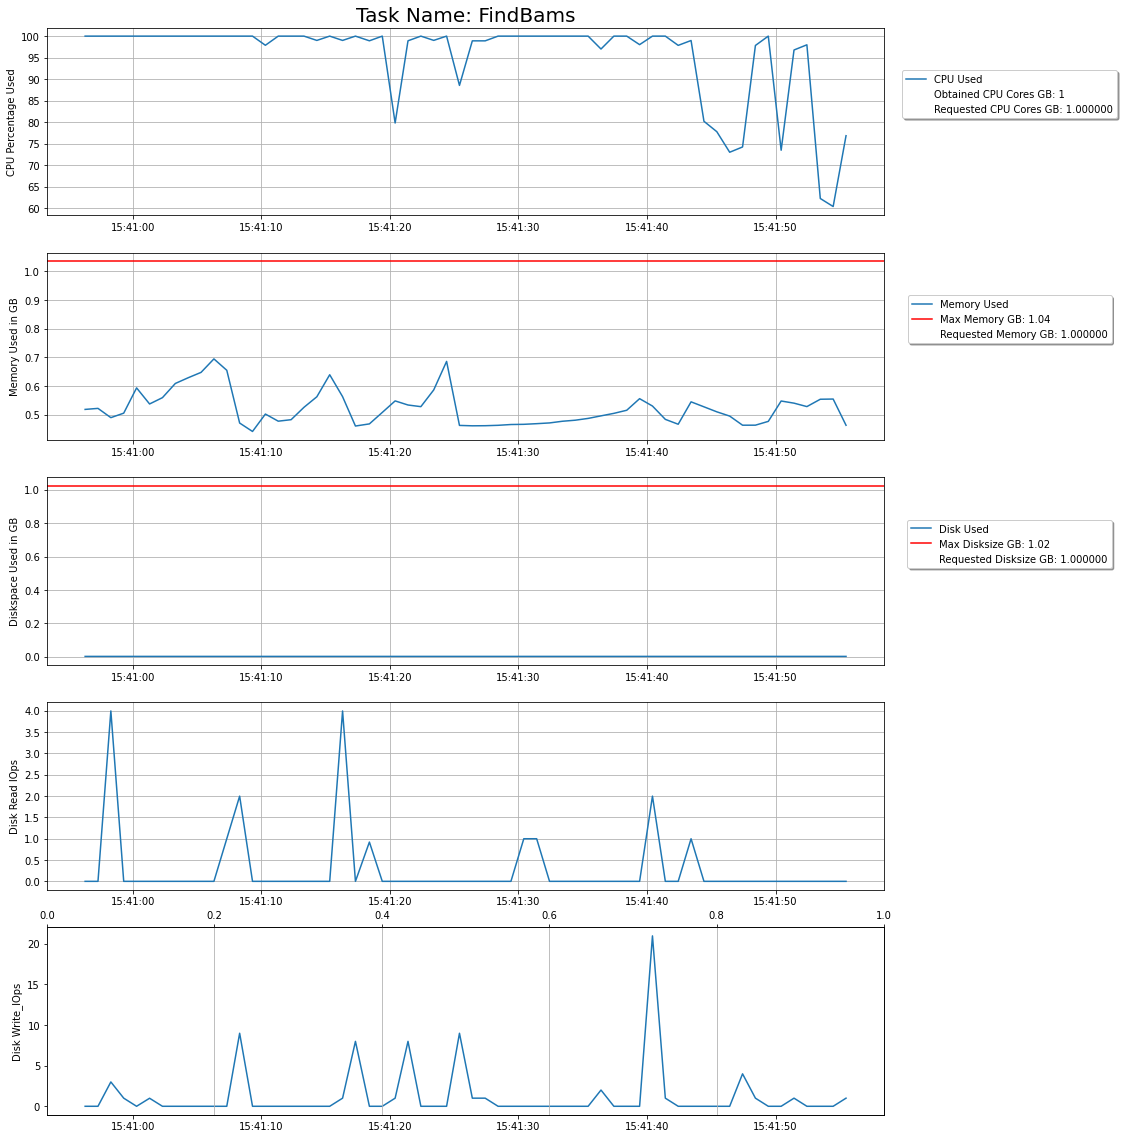

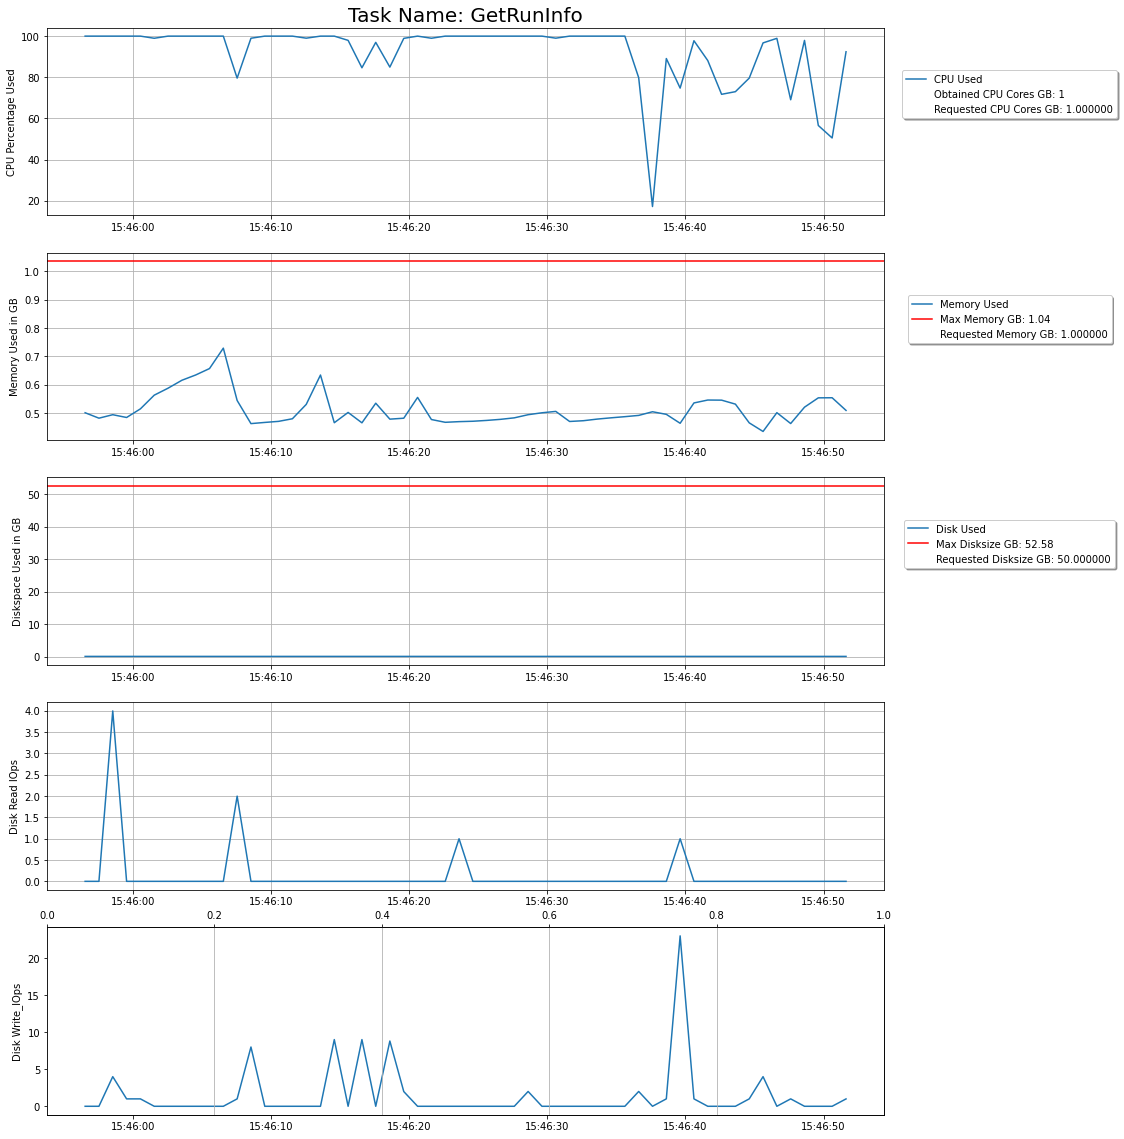

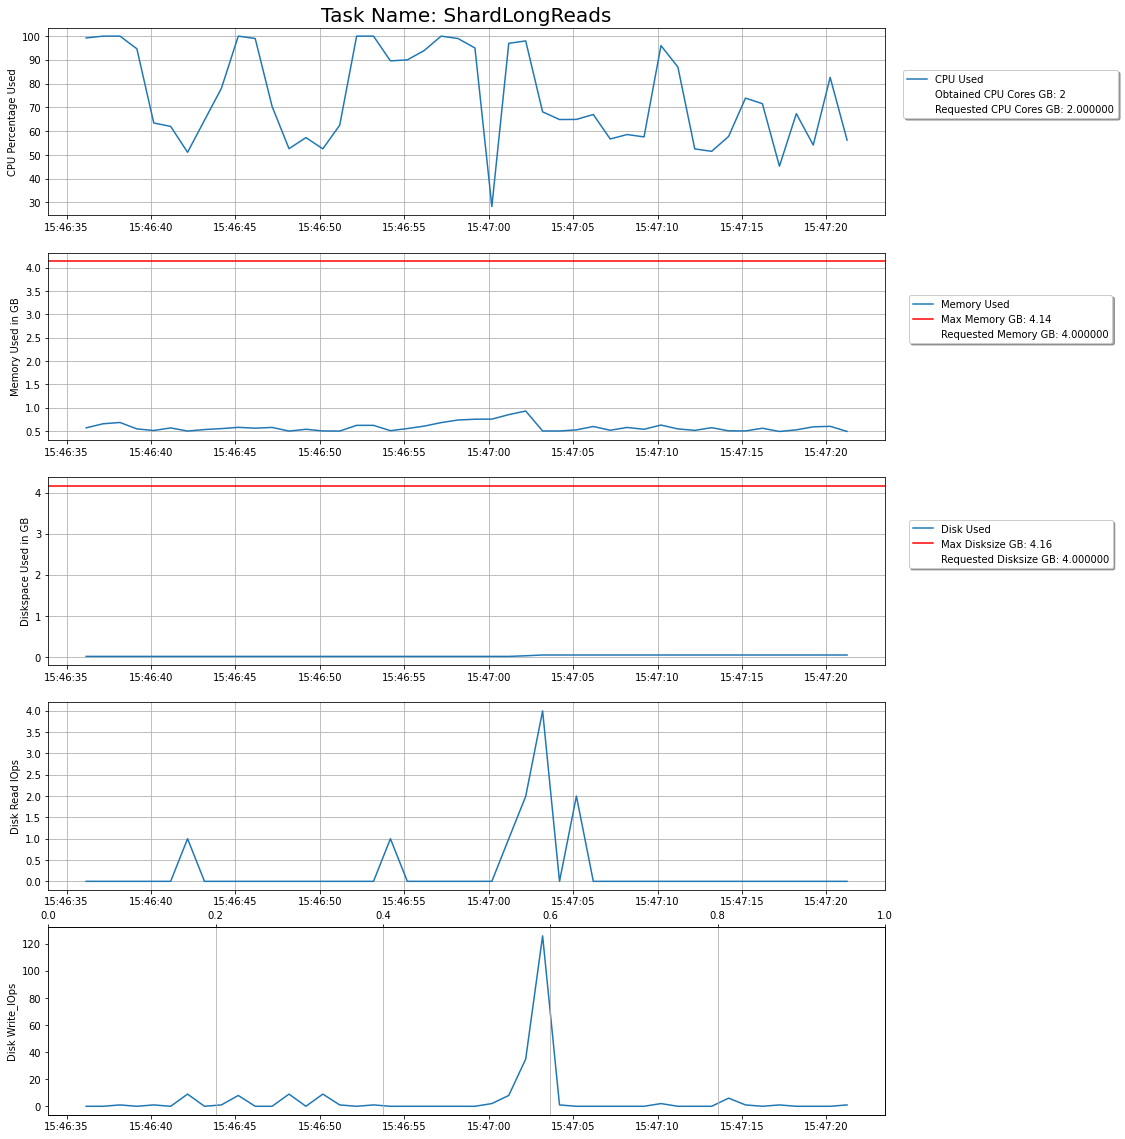

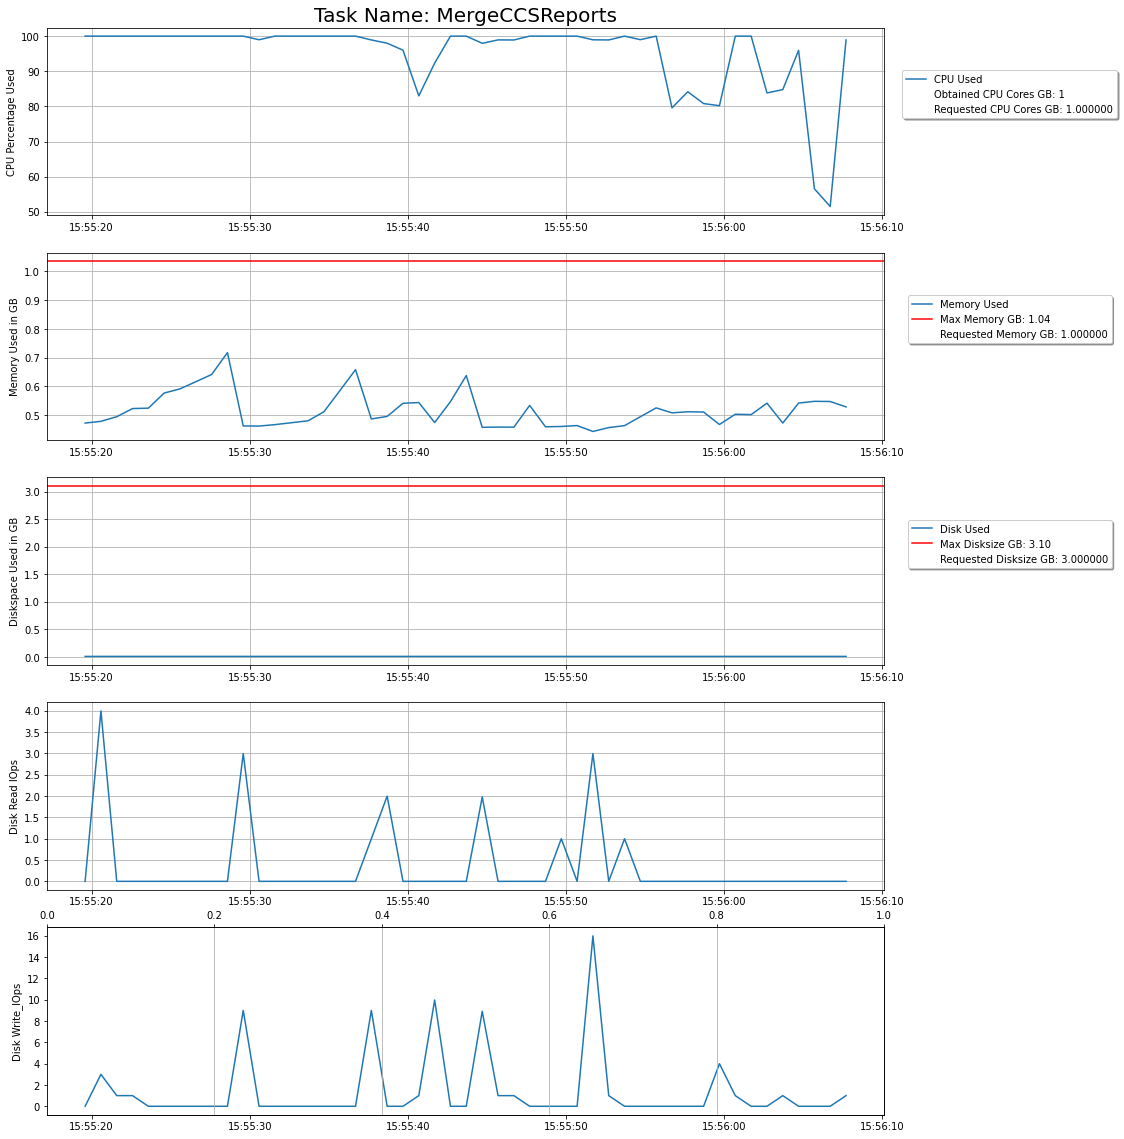

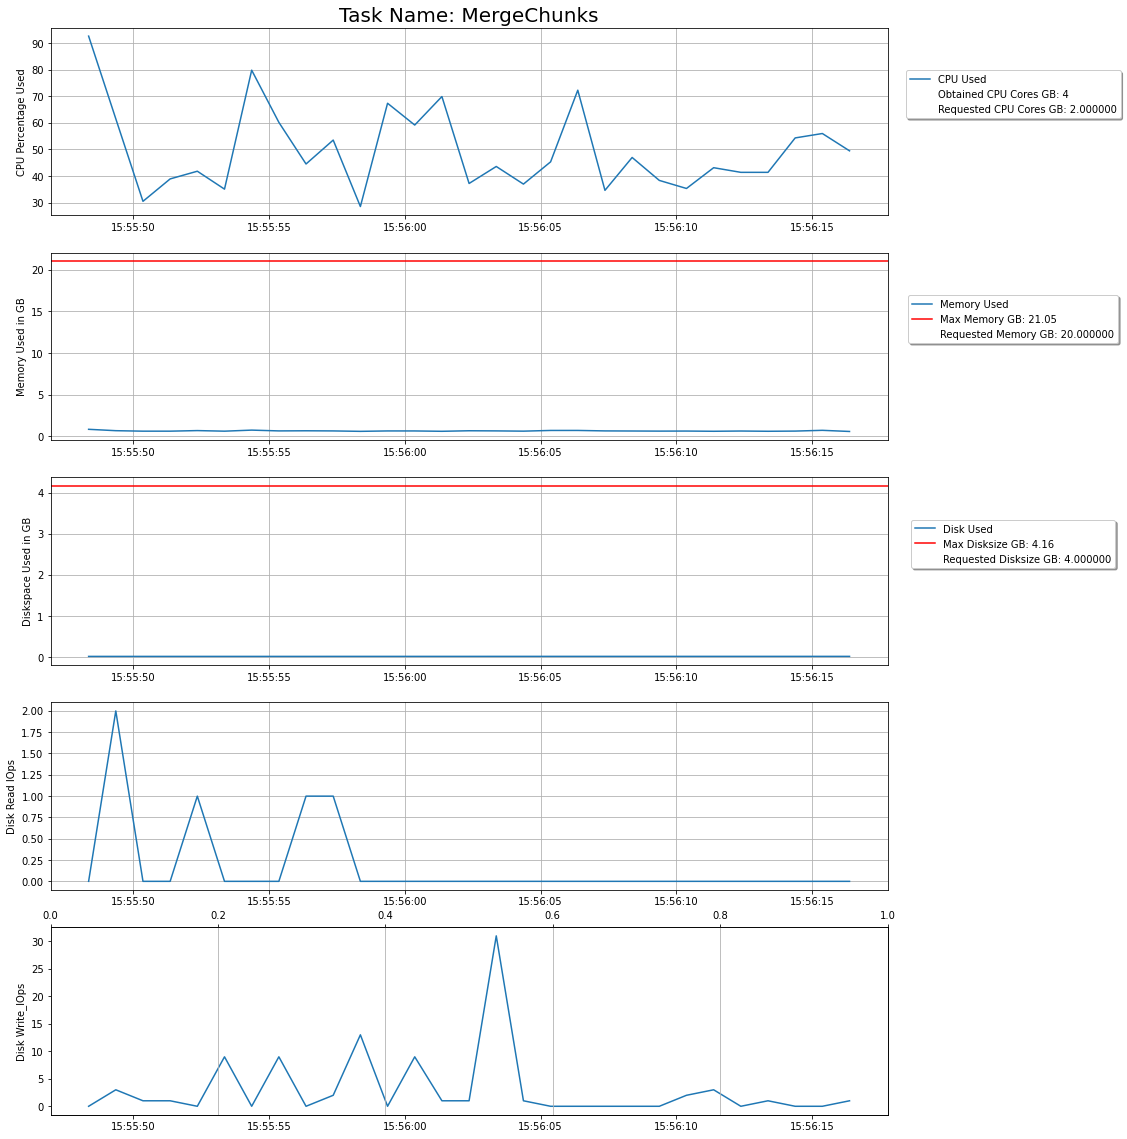

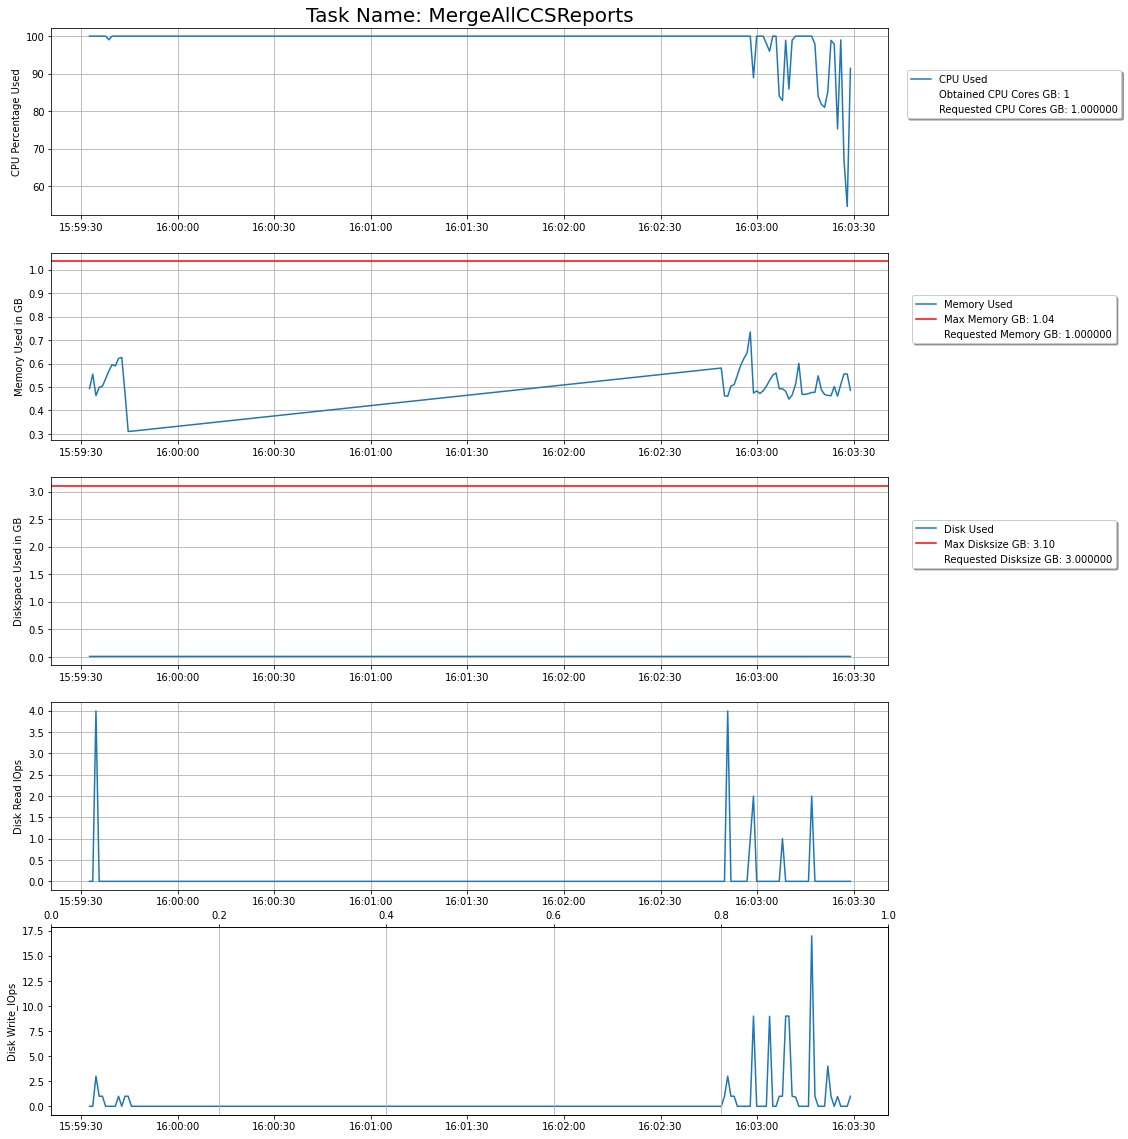

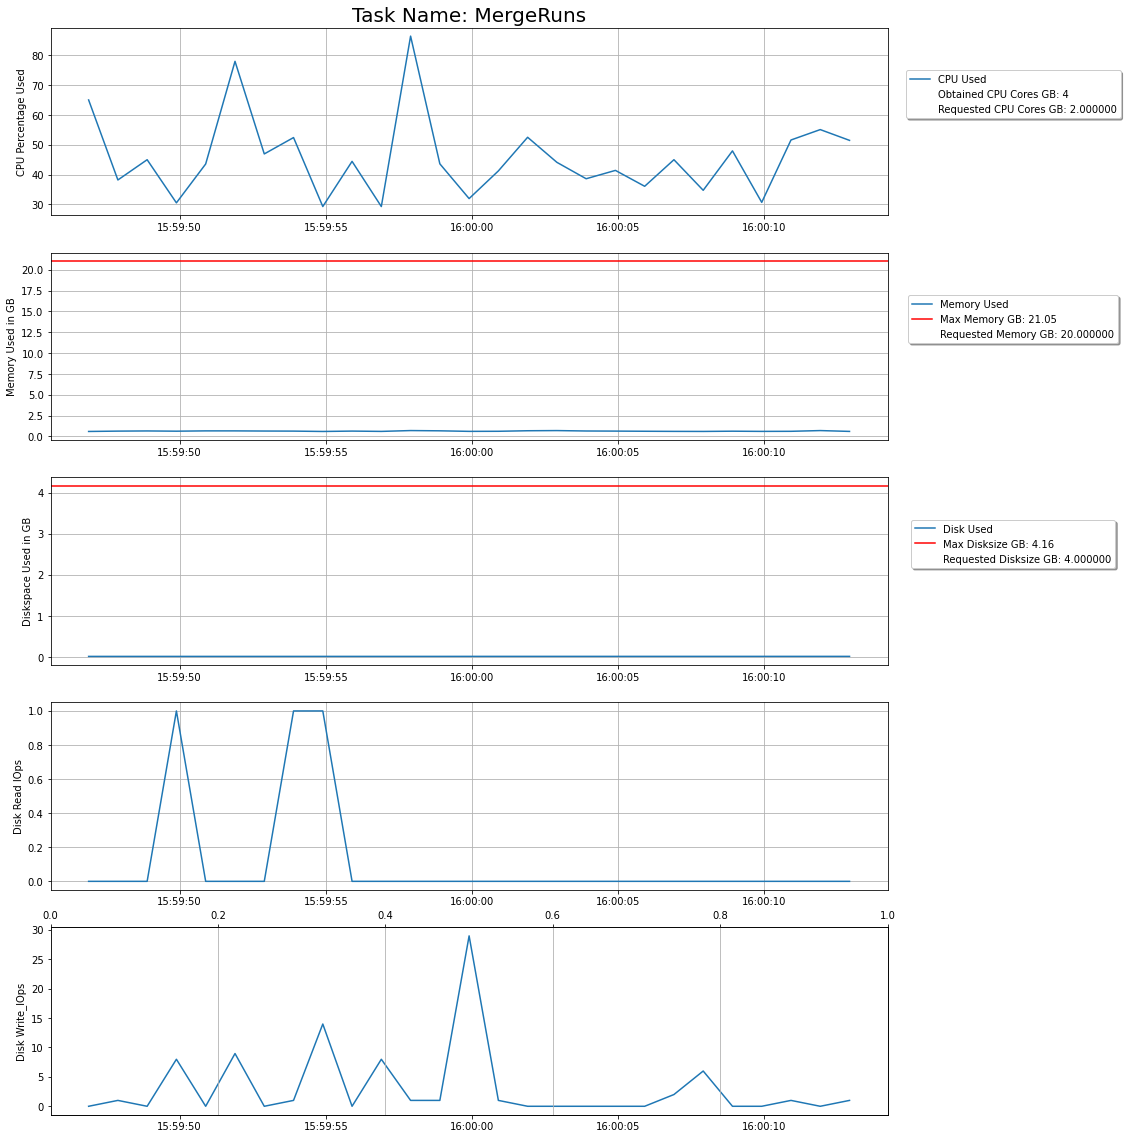

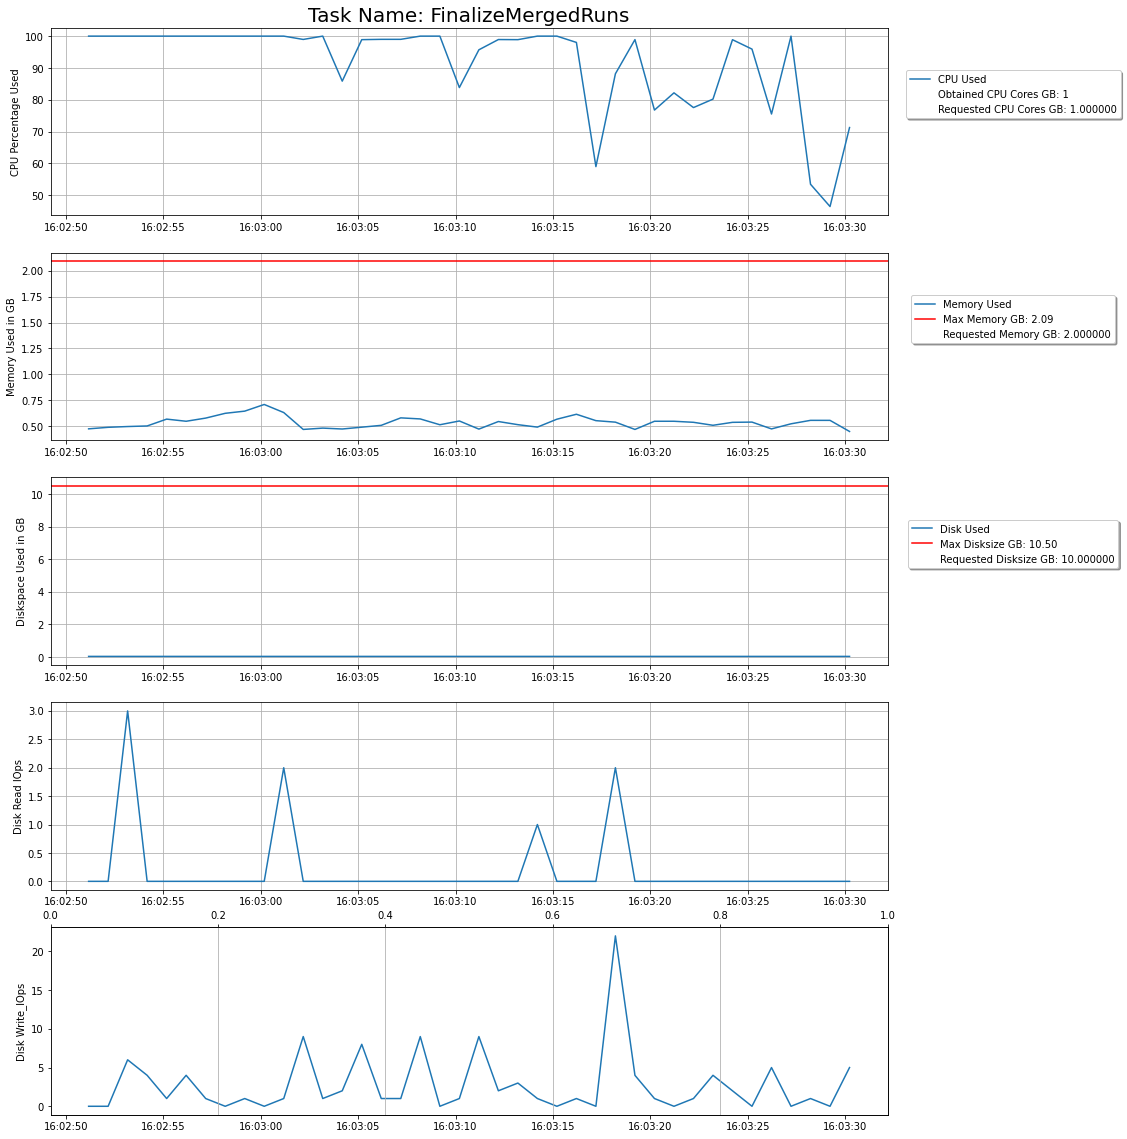

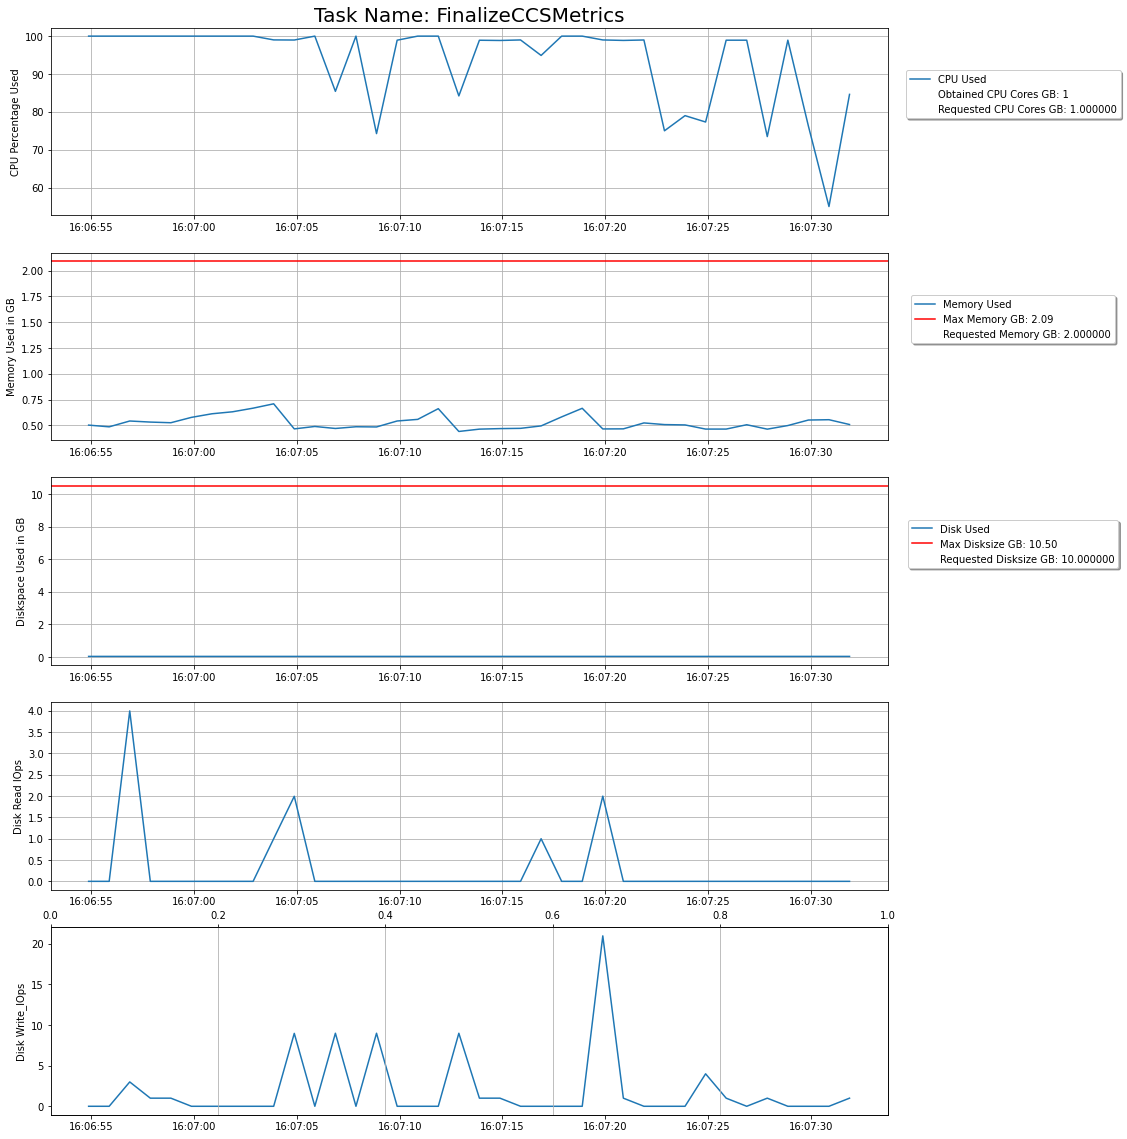

In [62]:
####   DRAFT   ####

with PdfPages(WORKFLOWID + '_resource_monitoring.pdf') as pdf:

    for task_name in TaskNames:
        
        df_metric_task=df_metric.loc[df_metric['task_call_name'] == task_name]
        df_meta_task=df_meta.loc[df_meta['task_call_name'] == task_name]
        df_metric_task=df_metric_task.sort_values(by='timestamp', ascending=False)

        # create an array for list coloumns
        cpu_used_percent_array = [np.asarray(x).max() for x in df_metric_task.cpu_used_percent]
        disk_used_gb_array = [np.asarray(x).max() for x in df_metric_task.disk_used_gb]
        disk_read_iops_array = [np.asarray(x).max() for x in df_metric_task.disk_read_iops]
        disk_write_iops_array = [np.asarray(x).max() for x in df_metric_task.disk_write_iops]

        runtime_list= df_meta_task.iloc[0].at['runtime_inputs']
        runtime_dic={}
        for i, element in enumerate(runtime_list):
            if re.search("default_attr", element["key"]) or re.search("runtime_attr_override", element["key"]):
                continue
            else:
                k = element["key"].replace("[", "").replace("]", "").replace("runtime_attr", "").replace("\"", "", 2)
                v = element["value"]
                runtime_dic[k]=v

        plt.subplot(5, 1, 1)
        plt.title("Task Name: " + task_name, fontsize=20)
        plt.plot(df_metric_task.timestamp.astype('O'), cpu_used_percent_array, label='CPU Used')
        plt.plot([], [], ' ', label='Obtained CPU Cores GB: {}' .format(df_meta_task.iloc[0].at['cpu_obtained']))
        plt.plot([], [], ' ', label='Requested CPU Cores GB: {}' .format(runtime_dic["cpu_cores"]))
        plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)
        plt.ylabel('CPU Percentage Used')
        plt.grid(True)

        plt.subplot(5, 1, 2)
        plt.plot(df_metric_task.timestamp.astype('O'), df_metric_task.mem_used_gb, label='Memory Used')
        plt.axhline(y=df_meta_task.iloc[0].at['mem_gb_obtained'], color='r', label='Max Memory GB: %.2f' %(df_meta_task.iloc[0].at['mem_gb_obtained']))
        plt.plot([], [], ' ', label='Requested Memory GB: {}' .format(runtime_dic["mem_gb"]))
        plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)
        plt.ylabel('Memory Used in GB')
        plt.grid(True)

        plt.subplot(5, 1, 3)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_used_gb_array, label='Disk Used')
        plt.axhline(y=max(df_meta_task.iloc[0].at['disk_gb_obtained']), color='r', label='Max Disksize GB: %.2f' %(max(df_meta_task.iloc[0].at['disk_gb_obtained'])))
        plt.plot([], [], ' ', label='Requested Disksize GB: {}' .format(runtime_dic["disk_gb"]))
        plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)
        plt.ylabel('Diskspace Used in GB')
        plt.grid(True)

        plt.subplot(5, 1, 4)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_read_iops_array)
        plt.ylabel('Disk Read IOps')
        plt.grid(True)

        plt.subplot(5, 1, 5)
        plt.plot(df_metric_task.timestamp.astype('O'), disk_write_iops_array)
        plt.ylabel('Disk Write_IOps')
        plt2 = plt.twiny()
        plt.grid(True)
        
        pdf.savefig()
        plt.show()
        plt.close()

In [212]:
!gsutil cp ./${WORKFLOWID}_resource_monitoring.png gs://bshifaw-bucket

CommandException: No URLs matched: ./bcb5d62-434b-4982-9969-8d50d99a4a98_resource_monitoring.png


In [ ]:
Refractoring

adding another pdf for input sizes and stuff

keys
the resources that was provided 
the resources that was requested

save each task plots as pdf
concatante each pdf